# Image Classification with the PyTorch Caltech-101 dataset
## using trained from scratch and pretrained AlexNet, performing Hyperparameters tuning and Data Augmentation

This homework was completed as a part of the homeworks for the Machine Learning and Deep Learning course of the Data Science and Engineering Master's Degree at Politecnico di Torino.

In this homework we will work with the Caltech-101 dataset from PyTorch, which is composed of 101 categories of images such as animals or common objects.

The purpose of this homework is to become familiar with the PyTorch framework, the structure of Convolutional Neural Networks and also to try different approaches for Image Classification tasks in Deep Learning, such as:

* Training from scratch a deep model
* Use Transfer Learning from pre-trained deep models
* Use Data Augmentation approach

The pre-built deep model that will be used is the famous Convolutional Neural Network "AlexNet".


In [1]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'
!rm -rf HW2

import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data preparation
### Set arguments, define Data Preprocessing, prepare dataset and dataloaders

The default arguments given from the description of the homework are:

* **DEVICE** = 'cuda'
* **NUM_CLASSES** = 102 
* **BATCH_SIZE** = 256 
* **LR** = 0.001           
* **MOMENTUM** = 0.9      
* **WEIGHT_DECAY** = 5e-5  
* **NUM_EPOCHS** = 30
* **STEP_SIZE** = 20   
* **GAMMA** = 0.1    
* **LOG_FREQUENCY** = 10

Also, the basic transformations applied on the whole dataset are:

* Resizing the input PIL image to 256
* Crop a central square patch of 224 in order to fit AlexNet requirements 
  (3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.)
* Transform the image into torch.Tensor
* Normalize the image with mean and standard deviation
  [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
  
The dataset is prepared by means of my custom implementation of the Caltech class, which is available in
[my GitHub repository of this project](https://github.com/cpeluso/HW2-Image-Classification.git).

This class *does not take into consideration* the BACKGROUND_GOOGLE class of the Caltech101 dataset.

In order to split train and test set, the class utilize two textual files, "train.txt" and "test.txt" in which the dataset is splitted (ratio 2:1).

* "train.txt" contains 5786 image names
* "test.txt" contains 2893 image names

In order to split the train set into train and validation set, the **train_eval_split()** method of the class allows to:

* for each class of the input set, split the images equally between the train and validation set
* generate approximately two sets of equal size

Finally, the result are three datasets of equal size (ratio 1:1:1).

*   **Set Arguments**
*   **Define Data Preprocessing**
*   **Prepare Dataset**
*   **Prepare Dataloaders**


In [6]:
# Initialize Loader
loader = Loader()

# Set arguments
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.load_default_parameters()

# Define Data Preprocessing
train_transform, eval_transform = loader.load_default_transformations()

# Prepare Dataset

## Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

## Clone personal github repository with the custom caltech dataset
if not os.path.isdir('./HW2'):
  !git clone https://github.com/cpeluso/HW2-Image-Classification.git
  !mv 'HW2-Image-Classification' 'HW2'

from HW2.caltech_dataset import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'

## Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

## Split the indexes for your train split and eval split
train_indexes, val_indexes = train_dataset.train_eval_split()

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes) 

output.clear()

## Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Prepare Dataloaders
val_dataloader, train_dataloader, test_dataloader = loader.load_dataloaders()

# Initialize Manager
manager = TrainValidateTestManager()

Train Dataset: 2895
Valid Dataset: 2889
Test Dataset: 2893


## Training from scratch

For all these runs:
* At every epoch the model was evaluated on the validation set
* The best model (at a certain epoch)  - based on the accuracy on the validation set - was saved in a .pth file.

### Training AlexNet from scratch with default parameters

Training the network with the default parameters introduced before in the **Data preparation** step, lead the CNN to a 16% of accuracy in the validation set.

In fact, the learning rate at 0.001 is too low in order to train the network in only 30 epochs.<br/>
Moreover, the default step size is equal to 20: so, for the last 10 epochs, the learning rate is set to 0.0001 (the gamma parameter is equal to 0.1) and the model converges really slowly (and of course the loss decreases slowly).




<Figure size 432x288 with 0 Axes>

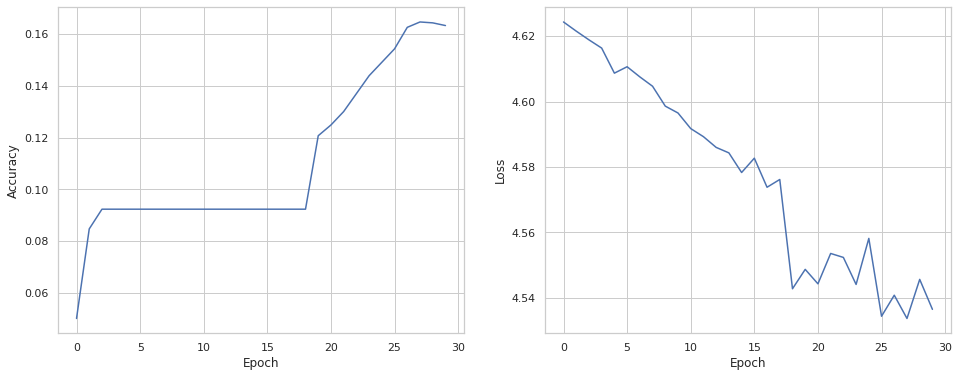

In [0]:
# Prepare network
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Prepare training
## Define loss function
criterion = nn.CrossEntropyLoss() 

parameters_to_optimize = net.parameters()

## Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

manager.train_net_from_scratch(net, scheduler, optimizer, criterion)

### Training AlexNet from scratch with hyperparameters tuning

The set of hyperparameters **(LR, STEP_SIZE, NUM_EPOCHS)** I chose is the following:
1. **(0.01, 15, 30)**\
   First of all I only increased the learning rate parameter of 10x factor, in order to visualize which improvements the model could reach.<br/>
   In 30 epochs the model reach an accuracy of 27% circa, which is already way better than the previous training.<br/> Moreover, from the accuracy and in particular from the loss plot over the epochs, we can see that with these parameters the loss is decreasing following a good trend.
2. **(0.01, 30, 40)**\
   In order to discover how good the model with the previous hyperparameter set could be, I increased the number of epochs of the training to 40 and also the step size to 30.<br/>
   With this set of hyperparameters, I left more epochs with an higher learning rate in order to push more the model to increase it's accuracy on the validation set.<br/>
   Fortunately, the learning rate is not higher enough to let the model diverge: on the contrary, this set led the model to a 43% of accuracy.<br/>
   *I also tried with 60 epochs instead of 40, but the accuracy remains constant beyond a certain epoch.*
3. **(0.05, 15, 30)**\
   With this last set of hyperparameters I tried to find the maximum learning rate for which the model does not diverge.
   Using 0.05 as learning rate, the accuracy follows a good trend and reach 45% in 30 epochs.
   
I also tried with
4. **(0.1, 15, 30)**<br/>
   However, with this last set, the learning rate is too high and the model diverges.

<Figure size 432x288 with 0 Axes>

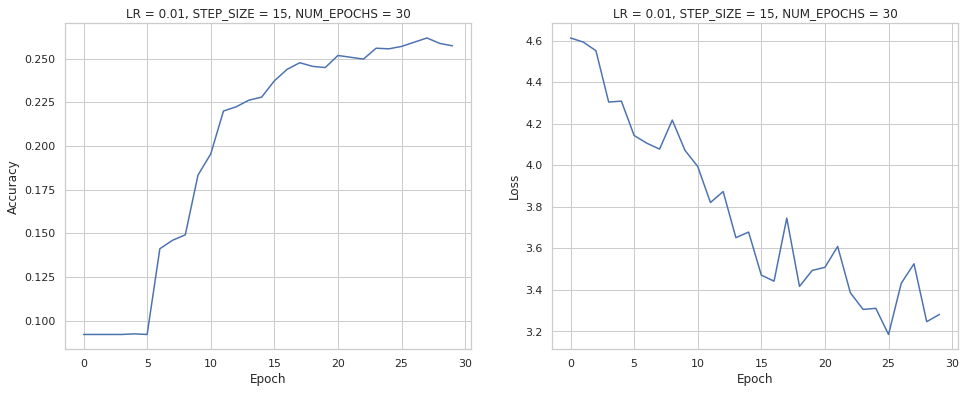

<Figure size 432x288 with 0 Axes>

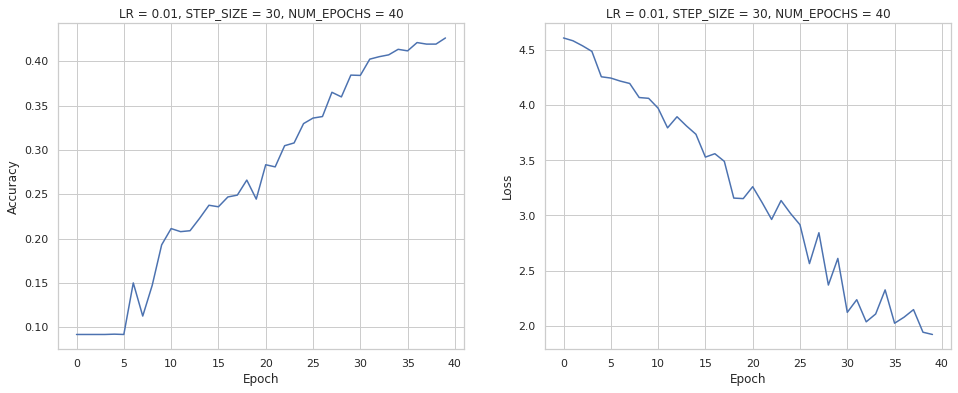

<Figure size 432x288 with 0 Axes>

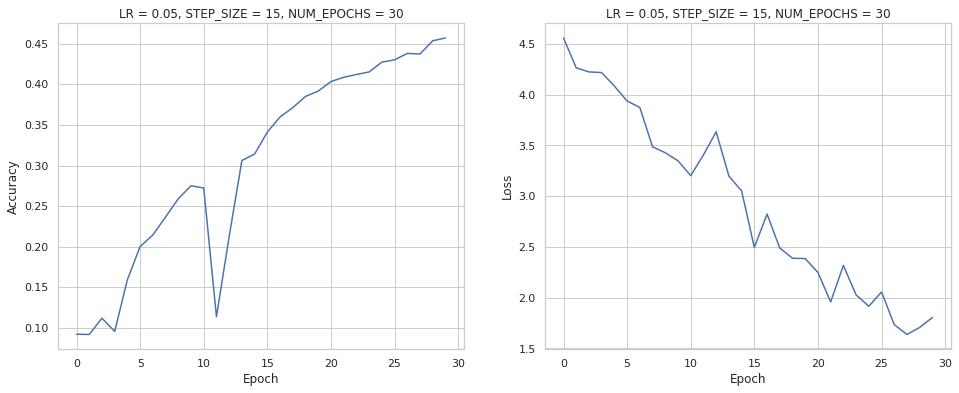

In [0]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.load_default_parameters()

# Load sets of hyperparameters
# (LR, STEP_SIZE, NUM_EPOCHS)
hyperparameters_sets = loader.load_hyperparameters_sets()

# Train neural network from scratch with Hyperparameters tuning
nets_best_accuracy = manager.train_net_from_scratch_with_hyperparameters(net, scheduler, optimizer, criterion, hyperparameters_sets)

### Validation and test of the best model found

The best model found was the third mentioned in the **Training AlexNet from scratch with hyperparameters tuning** step.

As we expected, the accuracy of the model on the validation set and on the test set is 45.5% circa.

In [0]:
# Get best model found at its best epoch
max_acc_model_filename = get_max_accuracy_model_filename(nets_best_accuracy)

# Validate neural network on validation set
net = manager.validate_net(max_acc_model_filename)

# Test neural network on test set
manager.test_net(net)

  0%|          | 0/12 [00:00<?, ?it/s]


Validation Accuracy: 0.45709342560553634


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Test Accuracy: 0.45523677843069477


## Transfer Learning

For all these runs:
* At every epoch the model was evaluated on the validation set
* The best model (at a certain epoch)  - based on the accuracy on the validation set - was saved in a .pth file.

### Train AlexNet pretrained with hyperparameters tuning

The set of hyperparameters **(LR, STEP_SIZE, NUM_EPOCHS)** I chose is the following:<br/>
The first two sets are the same used for the **Training from scratch** step.

1. **(0.01, 15, 30)**, **(0.01, 30, 40)**\
   I started the hyperparameters tuning step with these two sets in order to explore if this *relatively* high learning rate could lead the model to a good accuracy or not.<br/>
   It ended up being a good choice, because - as we expected from Transfer Learning - the accuracy was already high in the first epochs and also grown rapidly (high start, fast learning curve).<br/>
   The asymptote is already a good one for these sets, approximately around 85+ %, and it is reached very fast.<br/>
   With more epochs and an higher step size (set 2.) we have a little increase of the accuracy in the last epochs. However, the learning curve is not increasing enough epoch-by-epoch to conduct me to increase again the number of epochs.<br/>
   The accuracy reached is 86%, on the validation set. 
3. **(0.001, 25, 30)**\
   With this last set of hyperparameters I tried to understand if I forced too much the pretrained AlexNet to re-learn its weights for the given dataset.<br/>
   So, I set a 10x lower learning rate and the results did not pay. Probably, the ImageNet dataset - in which the AlexNet is trained - is slightly different from the Caltech-101, so an higher learning rate is necessary to obtain good results *in few epochs*.
   However, the accuracy on the validation set at the best epoch is around 80%, which is still quite good. <br/>

<Figure size 432x288 with 0 Axes>

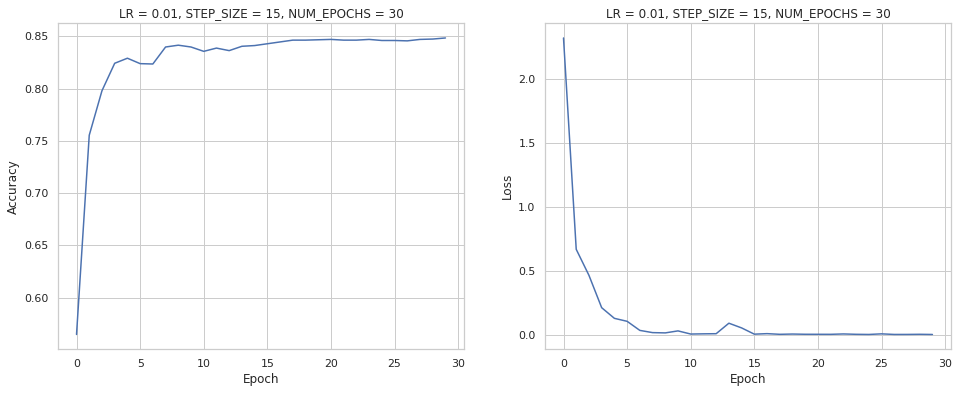

<Figure size 432x288 with 0 Axes>

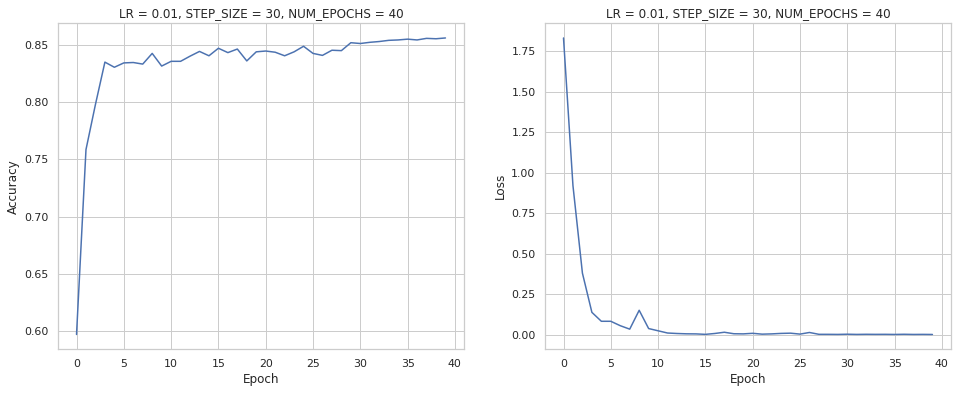

<Figure size 432x288 with 0 Axes>

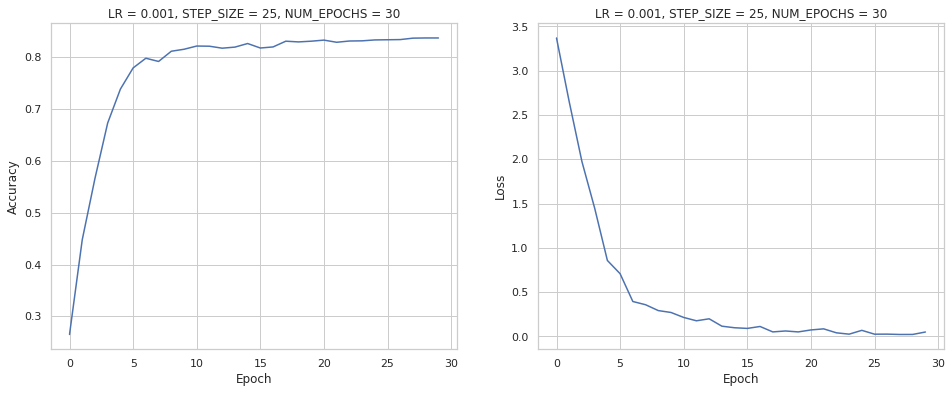

In [0]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.load_default_parameters()

# Load sets of hyperparameters
# (LR, STEP_SIZE, NUM_EPOCHS)
hyperparameters_sets = loader.load_hyperparameters_sets_for_pretrained_net()

# Load proper transformations for pretrained AlexNet
train_transform, eval_transform = loader.load_alexnet_pretrained_transformations()

# Train pretrained neural network with Hyperparameters tuning
manager.train_pretrained_net_with_hyperparameters(net, scheduler, optimizer, criterion, hyperparameters_sets)

### Experiment by training only the fully connected layers and only the convolutional layers 
#### using the best hyperparameters found in the previous step

* **Training only fully connected layers**<br/>
  As we expected, the AlexNet already trained on the ImageNet dataset extracts useful features since the first epochs. <br/>
  Of course, this is true because the images of the Caltech101 dataset belong to the same domain of the ImageNet dataset ones, and so the AlexNet has already develop the correct weights to understand and recognize those images.<br/>
  However, comparing this run with the one in which I was training the whole network, we can see that adjust a little the weights of the convolutional layers guarantees a slightly higher accuracy in long terms.
  The accuracy reached with this run is around 84.5%.
* **Training only convolutional layers**<br/>
  This process requires more epochs in order to obtain good results in terms of accuracy. In fact, the convolutional layers have to change more in order to readapt themselves to the classifier.<br/>
  Of course the accuracy (60%) of this run is way lower than the previous. 

<Figure size 432x288 with 0 Axes>

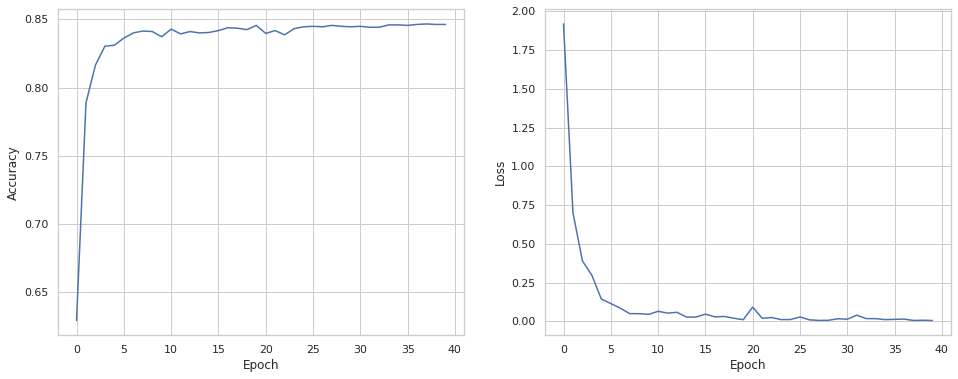

In [7]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.load_default_parameters()

# Set best hyperparameters obtained in the previous step
LR = 0.01
STEP_SIZE = 30
NUM_EPOCHS = 40

# Prepare Network
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

# Train only FC layers -> Freeze convolutional Layers
for param in net.features.parameters():
  param.requires_grad = False
  
# Prepare Training
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE)

manager.train_fc_layers_pretrained_net(net, scheduler, optimizer, criterion)

<Figure size 432x288 with 0 Axes>

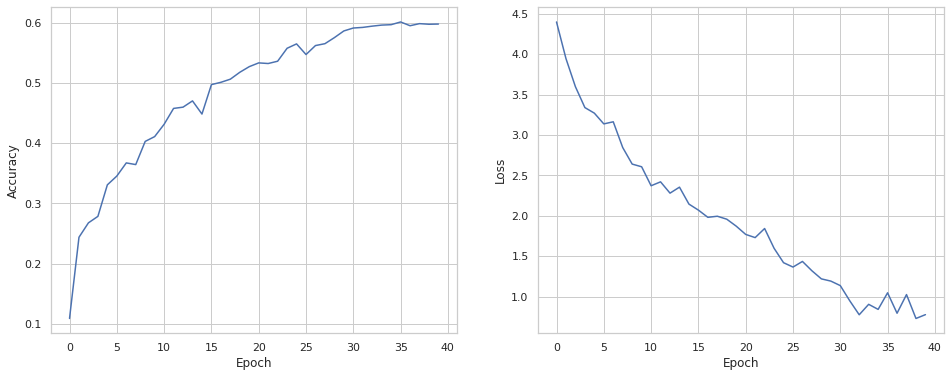

In [8]:
# Prepare Network
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

# Train only convolutional layers -> Freeze FC layers
for param in net.classifier.parameters():
  param.requires_grad = False

# Prepare Training
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE)

manager.train_conv_layers_pretrained_net(net, scheduler, optimizer, criterion)


## Data augmentation

For all these runs:
* At every epoch the model was evaluated on the validation set
* The parameters used are the default ones, described in the first point of the project.

The set of transformations I chose is the following:<br/>

1. **Color jitter**
2. **Horizontal flip**
3. **Horizontal flip, vertical flip, grayscale**

This three transformations I applied are merely for testing the effectiveness of Data Augmentation for **this task**.

I started with two non invasive transformations and then I combined three transformations in order to mess up the data of my dataset.
The results are quite similar between them, and I associate this with the fact that the pretrained AlexNet has already seen millions of images, and a few thousands of images modified are not useful to train the model also for this specific task. In contrary, the model cannot learn even the basic features of the images in the current dataset.

However, the accuracy is around 80%, so no improvements compared to the previous task.


<Figure size 432x288 with 0 Axes>

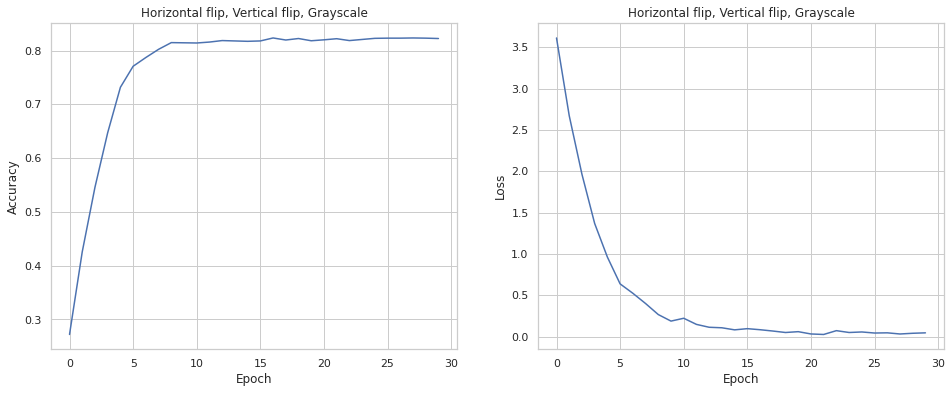

<Figure size 432x288 with 0 Axes>

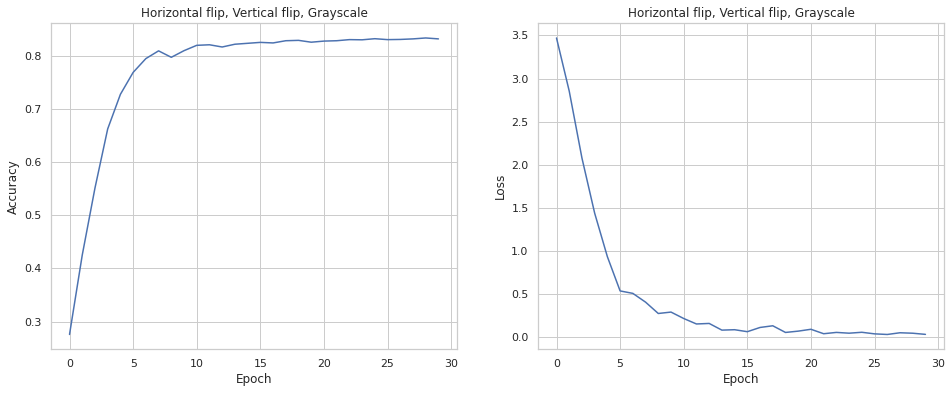

<Figure size 432x288 with 0 Axes>

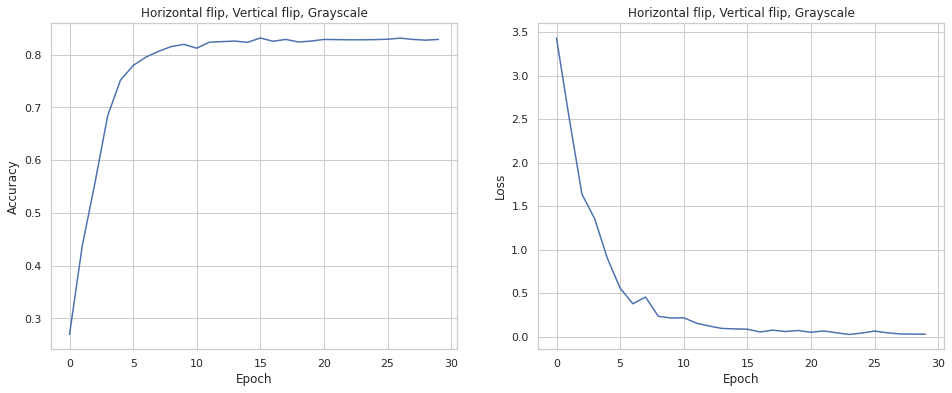

In [10]:
# Restore default parameters
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.load_default_parameters()

# Load sets of transformations
# (train_transform, eval_transform)
transformations_sets = loader.load_transformations_for_data_augmentation()

print(transformations_sets)

manager.train_pretrained_net_with_transformed_data(net, scheduler, optimizer, criterion, transformations_sets)

## Code

In [0]:
def plot_accuracies_and_losses(accuracies, losses, title=""):
  accuracy_df = pd.DataFrame(accuracies)
  accuracy_df = accuracy_df.astype(float)
  accuracy_df.columns=['Epoch','Accuracy']

  loss_df = pd.DataFrame(losses)
  loss_df = loss_df.astype(float)
  loss_df.columns=['Epoch','Loss']

  plt.figure()  
  sns.set(style = "whitegrid")
  fig, ax = plt.subplots(1, 2, figsize=(16, 6))

  sns.lineplot(x='Epoch',y='Accuracy',data=accuracy_df, markers=True, dashes=False,  ax = ax[0]).set_title(title)
  sns.lineplot(x='Epoch',y='Loss',data=loss_df, markers=True, dashes=False,  ax = ax[1]).set_title(title)

  return

def get_max_accuracy_model_filename(nets_best_accuracy):
  max_acc = 0
  max_acc_model_filename = ""
  for k in nets_best_accuracy:
    if nets_best_accuracy[k][1] > max_acc:
      max_acc = nets_best_accuracy[k][1]
      max_acc_model_filename = nets_best_accuracy[k][2]

  return max_acc_model_filename

In [0]:
class TrainValidateTestManager():
  def __init__(self):
    pass
  
  def train_net_from_scratch(self, net, scheduler, optimizer, criterion):
    global NUM_EPOCHS, train_dataloader
    
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    accuracies = []
    losses = []

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

      # Iterate over the dataset
      for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train() # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

      # Evaluate network on validation set
      accuracy = self.evaluate_neural_network_on_validation_set(net) 
      accuracies.append( (epoch, accuracy) )
      losses.append( (epoch, loss) )

      # Step the scheduler
      scheduler.step()

    output.clear()
    plot_accuracies_and_losses(accuracies, losses)
    return
    pass

  def train_net_from_scratch_with_hyperparameters(self, net, scheduler, optimizer, criterion, hyperparameters_sets):
    global train_dataloader

    # Define structures for accuracies and losses
    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()

    for hyperparameter_set in hyperparameters_sets:
      # Set LR, STEP_SIZE and NUM_EPOCHS 
      LR = hyperparameter_set[0]
      STEP_SIZE = hyperparameter_set[1]
      NUM_EPOCHS = hyperparameter_set[2]

      # Initialize structures for accuracies and losses
      print("\nHyperparameter set:")
      print(hyperparameter_set)
      accuracies[hyperparameter_set] = []
      losses[hyperparameter_set] = []
      
      # Prepare Network
      net = alexnet() 
      net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

      # Prepare Training
      criterion = nn.CrossEntropyLoss() 
      parameters_to_optimize = net.parameters() 
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
      net = net.to(DEVICE) 

      cudnn.benchmark 

      current_step = 0
      best_accuracy = float(0)
      filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step() 
          current_step += 1

        scheduler.step()
        
        # Evaluate network on validation set, save accuracy and loss
        accuracy = self.evaluate_neural_network_on_validation_set(net) 
        accuracies[hyperparameter_set].append( (epoch, accuracy) )
        losses[hyperparameter_set].append( (epoch, loss.item()))
        
        # Save the model if this epoch produced the best accuracy value on validation set
        if accuracy > best_accuracy:
          torch.save(net.state_dict(), filename)
          nets_best_accuracy[hyperparameter_set] = (epoch, accuracy, filename)
          best_accuracy = accuracy

      output.clear()

    # Plot results
    for hyperparameter_set in hyperparameters_sets:
      plot_accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                                "LR = " + str(hyperparameter_set[0]) + ", " + 
                                "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                                "NUM_EPOCHS = " + str(hyperparameter_set[2]))

    return nets_best_accuracy
    pass 

  def train_pretrained_net_with_hyperparameters(self, net, scheduler, optimizer, criterion, hyperparameters_sets):
    global train_dataloader
   
    # Define structures for accuracies and losses
    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()

    for hyperparameter_set in hyperparameters_sets:
      # Set LR, STEP_SIZE and NUM_EPOCHS 
      LR = hyperparameter_set[0]
      STEP_SIZE = hyperparameter_set[1]
      NUM_EPOCHS = hyperparameter_set[2]

      # Initialize structures for accuracies and losses
      print("\n Hyperparameter set:")
      print(hyperparameter_set)
      accuracies[hyperparameter_set] = []
      losses[hyperparameter_set] = []
      
      # Prepare Network
      net = alexnet(pretrained=True)
      net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

      # Prepare Training
      criterion = nn.CrossEntropyLoss()
      parameters_to_optimize = net.parameters() 
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
      net = net.to(DEVICE)

      cudnn.benchmark 

      current_step = 0
      best_accuracy = float(0)
      filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step() 
          current_step += 1

        scheduler.step()

        # Evaluate network on validation set, save accuracy and loss
        accuracy = self.evaluate_neural_network_on_validation_set(net) 
        accuracies[hyperparameter_set].append( (epoch, accuracy) )
        losses[hyperparameter_set].append( (epoch, loss.item()))
        
        # Save the model if this epoch produced the best accuracy value on validation set
        if accuracy > best_accuracy:
          torch.save(net.state_dict(), filename)
          nets_best_accuracy[hyperparameter_set] = (epoch, accuracy, filename)
          best_accuracy = accuracy

      output.clear()

    # Plot results
    for hyperparameter_set in hyperparameters_sets:
      plot_accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                                "LR = " + str(hyperparameter_set[0]) + ", " + 
                                "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                                "NUM_EPOCHS = " + str(hyperparameter_set[2]))
    return
    pass

  def train_fc_layers_pretrained_net(self, net, scheduler, optimizer, criterion):
    global NUM_EPOCHS, train_dataloader

    # Define structures for accuracies and losses
    losses = []
    accuracies = []

    cudnn.benchmark 

    current_step = 0

    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

      for images, labels in train_dataloader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 

        current_step += 1

      scheduler.step()
      
      # Evaluate network on validation set, save accuracy and loss
      accuracy = self.evaluate_neural_network_on_validation_set(net) 
      accuracies.append( (epoch, accuracy) )
      losses.append( (epoch, loss.item()))
        
    output.clear()

    # Plot results
    plot_accuracies_and_losses(accuracies, losses)
    return
    pass

  def train_conv_layers_pretrained_net(self, net, scheduler, optimizer, criterion):
    global NUM_EPOCHS, train_dataloader
    
    # Define structures for accuracies and losses
    losses = []
    accuracies = []

    cudnn.benchmark 

    current_step = 0

    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

      for images, labels in train_dataloader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 

        current_step += 1

      scheduler.step()
      
      # Evaluate network on validation set, save accuracy and loss
      accuracy = self.evaluate_neural_network_on_validation_set(net) 
      accuracies.append( (epoch, accuracy) )
      losses.append( (epoch, loss.item()))
        
    output.clear()

    # Plot results
    plot_accuracies_and_losses(accuracies, losses)
    return
    pass
  
  def train_pretrained_net_with_transformed_data(self, net, scheduler, optimizer, criterion, transformations_sets):
    global NUM_EPOCHS, train_dataloader
    # Define structures for accuracies and losses
    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()

    for transformations_set in transformations_sets:
      train_transform = transformations_set[0]
      eval_transform = transformations_set[1]
      title = transformations_set[2]

      val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
      train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

      # Initialize structures for accuracies and losses
      accuracies[transformations_set] = []
      losses[transformations_set] = []
      
      # Prepare Network
      net = alexnet(pretrained=True)
      net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

      # Prepare Training
      criterion = nn.CrossEntropyLoss()
      parameters_to_optimize = net.parameters() 
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
      net = net.to(DEVICE)

      cudnn.benchmark 

      current_step = 0
      best_accuracy = float(0)
      filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step() 
          current_step += 1

        scheduler.step()

        # Evaluate network on validation set, save accuracy and loss
        accuracy = self.evaluate_neural_network_on_validation_set(net) 
        accuracies[transformations_set].append( (epoch, accuracy) )
        losses[transformations_set].append( (epoch, loss.item()))
        
        # Save the model if this epoch produced the best accuracy value on validation set
        if accuracy > best_accuracy:
          torch.save(net.state_dict(), filename)
          nets_best_accuracy[transformations_set] = (epoch, accuracy, filename)
          best_accuracy = accuracy

      output.clear()

    # Plot results
    for transformations_set in transformations_sets:
      plot_accuracies_and_losses(accuracies[transformations_set],losses[transformations_set], transformations_set[2])

    return
    pass

  # Function called every training epoch to evaluate the accuracy on the validation set
  def evaluate_neural_network_on_validation_set(self, net):
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in val_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    # print('Validation Accuracy: {}'.format(accuracy))
    # print("\n")

    return accuracy
    pass

  def validate_net(self, max_acc_model_filename):
    global val_dataloader

    net = alexnet()
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    net.load_state_dict(torch.load(max_acc_model_filename))

    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(val_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print('\nValidation Accuracy: {}'.format(accuracy))

    return net
    pass

  def test_net(self, net):
    global test_dataloader

    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    print('\nTest Accuracy: {}'.format(accuracy))
    pass

In [0]:
class Loader():
  def __init__(self):
    global train_dataset, val_dataset, test_dataset

    self.default_transformations = (
            transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                          # 224 because torchvision's AlexNet needs a 224x224 input!
                                                          # Remember this when applying different transformations, otherwise you get an error
                                transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
            ]),
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
            ]))

    self.alexnet_pretrained_transformations = (
            transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                              # 224 because torchvision's AlexNet needs a 224x224 input!
                                                              # Remember this when applying different transformations, otherwise you get an error
                                transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
            ]),
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
            ]))

    self.hyperparameters_sets = [
            (0.01, 15, 30),
            (0.01, 30, 40),
            (0.05, 15, 30)
            ]

    self.hyperparameters_sets_for_pretrained_net = [
            (0.01, 15, 30),
            (0.01, 30, 40),
            (0.001, 25, 30)
            ]

    self.transformations_for_data_augmentation = [
            # COLOR JITTER
            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.CenterCrop(224),  
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Color jitter"),
              
            # HORIZONTAL FLIP
            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.CenterCrop(224),  
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Horizontal flip"),
              
            # HORIZONTAL FLIP, VERTICAL FLIP, GRAYSCALE 
            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.CenterCrop(224),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomVerticalFlip(p=0.1),  
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomVerticalFlip(p=0.1),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Horizontal flip, Vertical flip, Grayscale"),
            ]
    pass
  
  def load_default_parameters(self):
    default_DEVICE = 'cuda'

    default_NUM_CLASSES = 102 

    default_BATCH_SIZE = 256 

    default_LR = 0.001           
    default_MOMENTUM = 0.9      
    default_WEIGHT_DECAY = 5e-5  

    default_NUM_EPOCHS = 30
    default_STEP_SIZE = 20   
    default_GAMMA = 0.1    

    default_LOG_FREQUENCY = 10
    return (default_DEVICE, default_NUM_CLASSES, default_BATCH_SIZE, default_LR, default_MOMENTUM, default_WEIGHT_DECAY, default_NUM_EPOCHS, default_STEP_SIZE, default_GAMMA, default_LOG_FREQUENCY)
    pass

  def load_default_transformations(self):
    return self.default_transformations
    pass

  def load_alexnet_pretrained_transformations(self):
    return self.alexnet_pretrained_transformations
    pass
    
  def load_dataloaders(self):
    # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
    return (
            DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
            DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True),
            DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
           )
    pass
    
  def load_hyperparameters_sets(self):
    return self.hyperparameters_sets
    pass
    
  def load_hyperparameters_sets_for_pretrained_net(self):
    return self.hyperparameters_sets_for_pretrained_net
    pass
    
  def load_transformations_for_data_augmentation(self):
    return self.transformations_for_data_augmentation
    pass